# Autism Predictor – Modeling

Logistic Regression and Random Forest with clean preprocessing and clear evaluation.

In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

BASE = r"M:/DataScience/"
FIG_DIR = os.path.join(BASE, "reports", "figures")
os.makedirs(FIG_DIR, exist_ok=True)

df = pd.read_csv(os.path.join(BASE, "data", "autism_data.csv"))
print(df.shape)
df.head()


(1985, 28)


,CASE_NO_PATIENT'S,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,Global developmental delay/intellectual disability,Social/Behavioural Issues,Childhood Autism Rating Scale,Anxiety_disorder,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who_completed_the_test,ASD_traits
0,1,0,0,0,0,0,0,1,1,0,...,Yes,Yes,1,Yes,F,middle eastern,Yes,No,Family Member,No
1,2,1,1,0,0,0,1,1,0,0,...,Yes,Yes,2,Yes,M,White European,Yes,No,Family Member,Yes
2,3,1,0,0,0,0,0,1,1,0,...,Yes,Yes,4,Yes,M,Middle Eastern,Yes,No,Family Member,Yes
3,4,1,1,1,1,1,1,1,1,1,...,Yes,Yes,2,Yes,M,Hispanic,No,No,Family Member,Yes
4,5,1,1,0,1,1,1,1,1,1,...,Yes,Yes,1,Yes,F,White European,No,No,Family Member,Yes


In [4]:
# Map Yes/No -> 1/0 where applicable
for col in df.columns:
    if df[col].dtype == object:
        uniq = set(str(v).strip().lower() for v in df[col].dropna().unique())
        if uniq <= {"yes", "no"}:
            df[col] = df[col].str.strip().str.lower().map({"yes": 1, "no": 0})

# Encode categorical columns
cat_cols = [c for c in ["Sex","Ethnicity","Who_completed_the_test"] if c in df.columns]
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Target and features
y = df["ASD_traits"]
X = df.drop(columns=["CASE_NO_PATIENT'S","ASD_traits"], errors="ignore")

# Drop rows where the target variable y is NaN
# This is necessary because some values in the original 'ASD_traits' column might not be 'Yes' or 'No'
valid_indices = y.dropna().index
X = X.loc[valid_indices]
y = y.loc[valid_indices]


# Numeric imputation (simple): fillna with median
for c in X.columns:
    if X[c].dtype.kind in "biufc":
        X[c] = X[c].fillna(X[c].median())
    else:
        # any other leftover non-numeric -> label encode ad hoc
        X[c] = LabelEncoder().fit_transform(X[c].astype(str))

X.dtypes.head(), X.shape, y.value_counts()

(A1    int64
 A2    int64
 A3    int64
 A4    int64
 A5    int64
 dtype: object,
 (1985, 26),
 ASD_traits
 1    1074
 0     911
 Name: count, dtype: int64)

In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, " Test:", X_test.shape)
print("Class balance (train):")
print(y_train.value_counts(normalize=True).round(3))


Train: (1588, 26)  Test: (397, 26)
Class balance (train):
ASD_traits
1    0.541
0    0.459
Name: proportion, dtype: float64


In [6]:

# Scale numeric features for LR stability
scaler = StandardScaler(with_mean=False)  # sparse-safe if needed
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:,1]

print("== Logistic Regression ==")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix (LR):")
print(confusion_matrix(y_test, y_pred_lr))


== Logistic Regression ==
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       182
           1       0.98      0.96      0.97       215

    accuracy                           0.96       397
   macro avg       0.96      0.97      0.96       397
weighted avg       0.96      0.96      0.96       397

Confusion Matrix (LR):
[[177   5]
 [  9 206]]


In [7]:

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("== Random Forest ==")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix (RF):")
print(confusion_matrix(y_test, y_pred_rf))


== Random Forest ==
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       182
           1       1.00      1.00      1.00       215

    accuracy                           1.00       397
   macro avg       1.00      1.00      1.00       397
weighted avg       1.00      1.00      1.00       397

Confusion Matrix (RF):
[[182   0]
 [  0 215]]


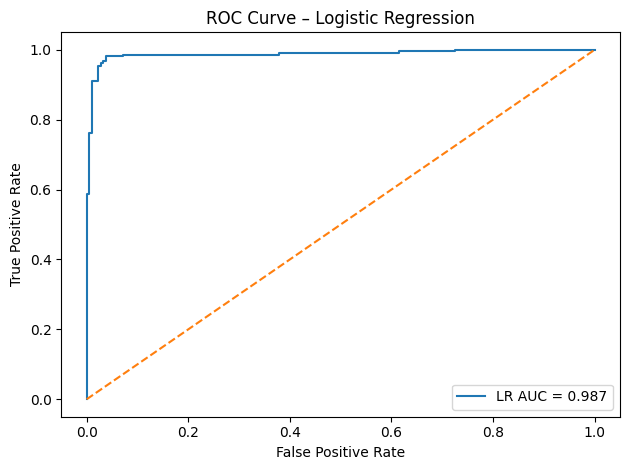

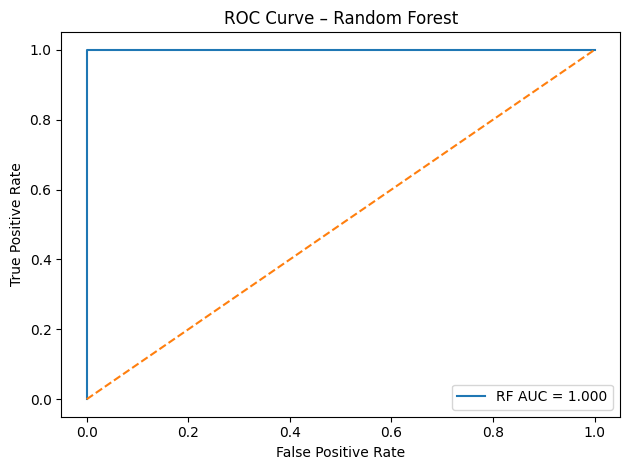

In [8]:

# ROC curve - LR
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'LR AUC = {roc_auc_lr:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'roc_lr.png'))
plt.show()

# ROC curve - RF
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f'RF AUC = {roc_auc_rf:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Random Forest')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'roc_rf.png'))
plt.show()


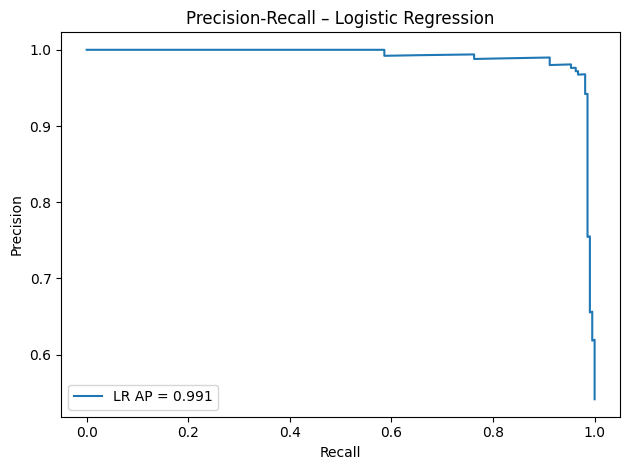

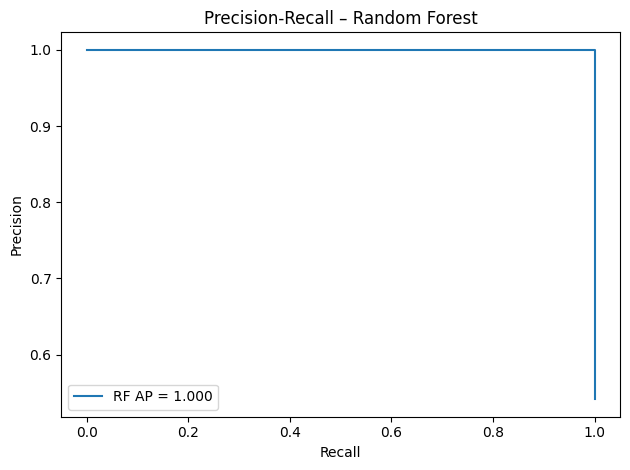

In [9]:

# Precision-Recall – LR
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_proba_lr)
ap_lr = average_precision_score(y_test, y_proba_lr)

plt.figure()
plt.plot(rec_lr, prec_lr, label=f'LR AP = {ap_lr:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall – Logistic Regression')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'pr_lr.png'))
plt.show()

# Precision-Recall – RF
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)
ap_rf = average_precision_score(y_test, y_proba_rf)

plt.figure()
plt.plot(rec_rf, prec_rf, label=f'RF AP = {ap_rf:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall – Random Forest')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'pr_rf.png'))
plt.show()


In [10]:

# Feature importances from RF
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(15)
feat_imp


Ethnicity                                             0.254162
Qchat_10_Score                                        0.217329
A6                                                    0.062473
A9                                                    0.058520
Sex                                                   0.056915
A7                                                    0.041088
A5                                                    0.038325
A2                                                    0.027955
A4                                                    0.026929
A1                                                    0.021586
Speech Delay/Language Disorder                        0.021319
A8                                                    0.020338
Social/Behavioural Issues                             0.019739
Depression                                            0.018214
Global developmental delay/intellectual disability    0.017743
dtype: float64

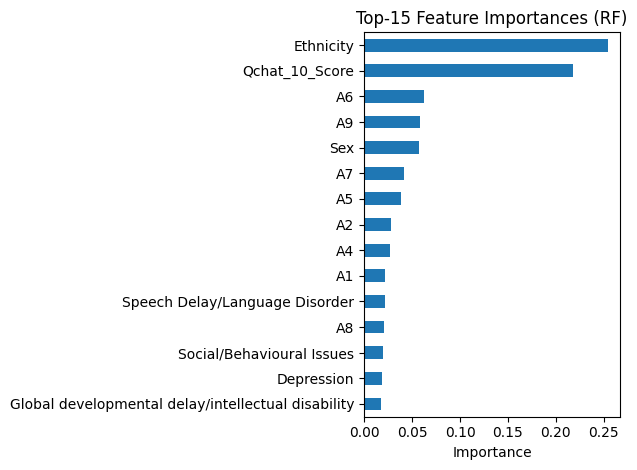

In [11]:

# Plot top-15 feature importances (matplotlib only)
plt.figure()
feat_imp.iloc[::-1].plot(kind='barh')
plt.xlabel('Importance')
plt.title('Top-15 Feature Importances (RF)')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'rf_feature_importance_top15.png'))
plt.show()
